In [ ]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from unet import Unet
from utils import rgb_to_lab, lab_to_rgb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

l1_loss = nn.L1Loss()

def read_and_resize_image(image_path, size=512):
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    new_size = min(width, height)
    left = (width - new_size) // 2
    top = (height - new_size) // 2
    right = left + new_size
    bottom = top + new_size
    image = image.crop((left, top, right, bottom))
    image = image.resize((size, size), Image.LANCZOS)
    return image

def preprocess_image(image):
    image_np = np.array(image).astype(np.float32)
    image_tensor = torch.from_numpy(image_np).to(device)
    
    l_chan, ab_chan = rgb_to_lab(image_tensor)
    return l_chan, ab_chan

def colorize_and_evaluate(model, l_chan, ab_chan):
    model.eval()
    with torch.no_grad():
        output = model(l_chan.unsqueeze(0))
        loss = l1_loss(output.squeeze(0), ab_chan)
    
    l_rgb = lab_to_rgb(l_chan.unsqueeze(0), torch.zeros_like(output))
    output_rgb = lab_to_rgb(l_chan.unsqueeze(0), output)
    target_rgb = lab_to_rgb(l_chan.unsqueeze(0), ab_chan.unsqueeze(0))
    
    l_rgb = l_rgb.squeeze().cpu().numpy()
    output_rgb = output_rgb.squeeze().cpu().numpy()
    target_rgb = target_rgb.squeeze().cpu().numpy()
    
    stacked_image = np.hstack((l_rgb, output_rgb, target_rgb))
    
    return stacked_image, loss.item()

def process_folder(model, folder_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    total_loss = 0

    for img_file in tqdm(image_files, desc="Processing images"):
        img_path = os.path.join(folder_path, img_file)
        original_image = read_and_resize_image(img_path)
        l_chan, ab_chan = preprocess_image(original_image)

        stacked_image, loss = colorize_and_evaluate(model, l_chan, ab_chan)
        total_loss += loss

        output_path = os.path.join(output_folder, f"colorized_{img_file}")
        Image.fromarray((stacked_image * 255).astype(np.uint8)).save(output_path)

    avg_loss = total_loss / len(image_files)
    return avg_loss

model = Unet().to(device)
# checkpoint = torch.load("model_unet_final.pth", map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model.load_state_dict(torch.load("unet_attn_final_finetune/model_unet_final.pth", map_location=device))

input_folder = "test_images"
output_folder = "test_images_output"

avg_loss = process_folder(model, input_folder, output_folder)

print(f"Average L1 Loss across all images: {avg_loss}")

def display_grid(output_folder, num_images=5):
    processed_images = [f for f in os.listdir(output_folder) if f.startswith("colorized_")]
    num_images = min(num_images, len(processed_images))
    
    fig, axes = plt.subplots(num_images, 1, figsize=(15, 5*num_images))
    if num_images == 1:
        axes = [axes]
    
    for i, img_file in enumerate(processed_images[:num_images]):
        img_path = os.path.join(output_folder, img_file)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

display_grid(output_folder, num_images=5)

Finetune 3

Model best checkpoint:  0.061676306916134696

Model final checkpoint: 0.0633884487407548

---

Finetune 4

Model best checkpoint:  0.06221018039754459

Model final checkpoint: 0.05993900181991713

Processing images: 100%|██████████| 7/7 [00:01<00:00,  6.19it/s]


Average L1 Loss across all images (with attention): 0.05993900607739176


Processing images: 100%|██████████| 7/7 [00:01<00:00,  6.07it/s]


Average L1 Loss across all images (no attention): 0.07006084706102099
Results with attention:


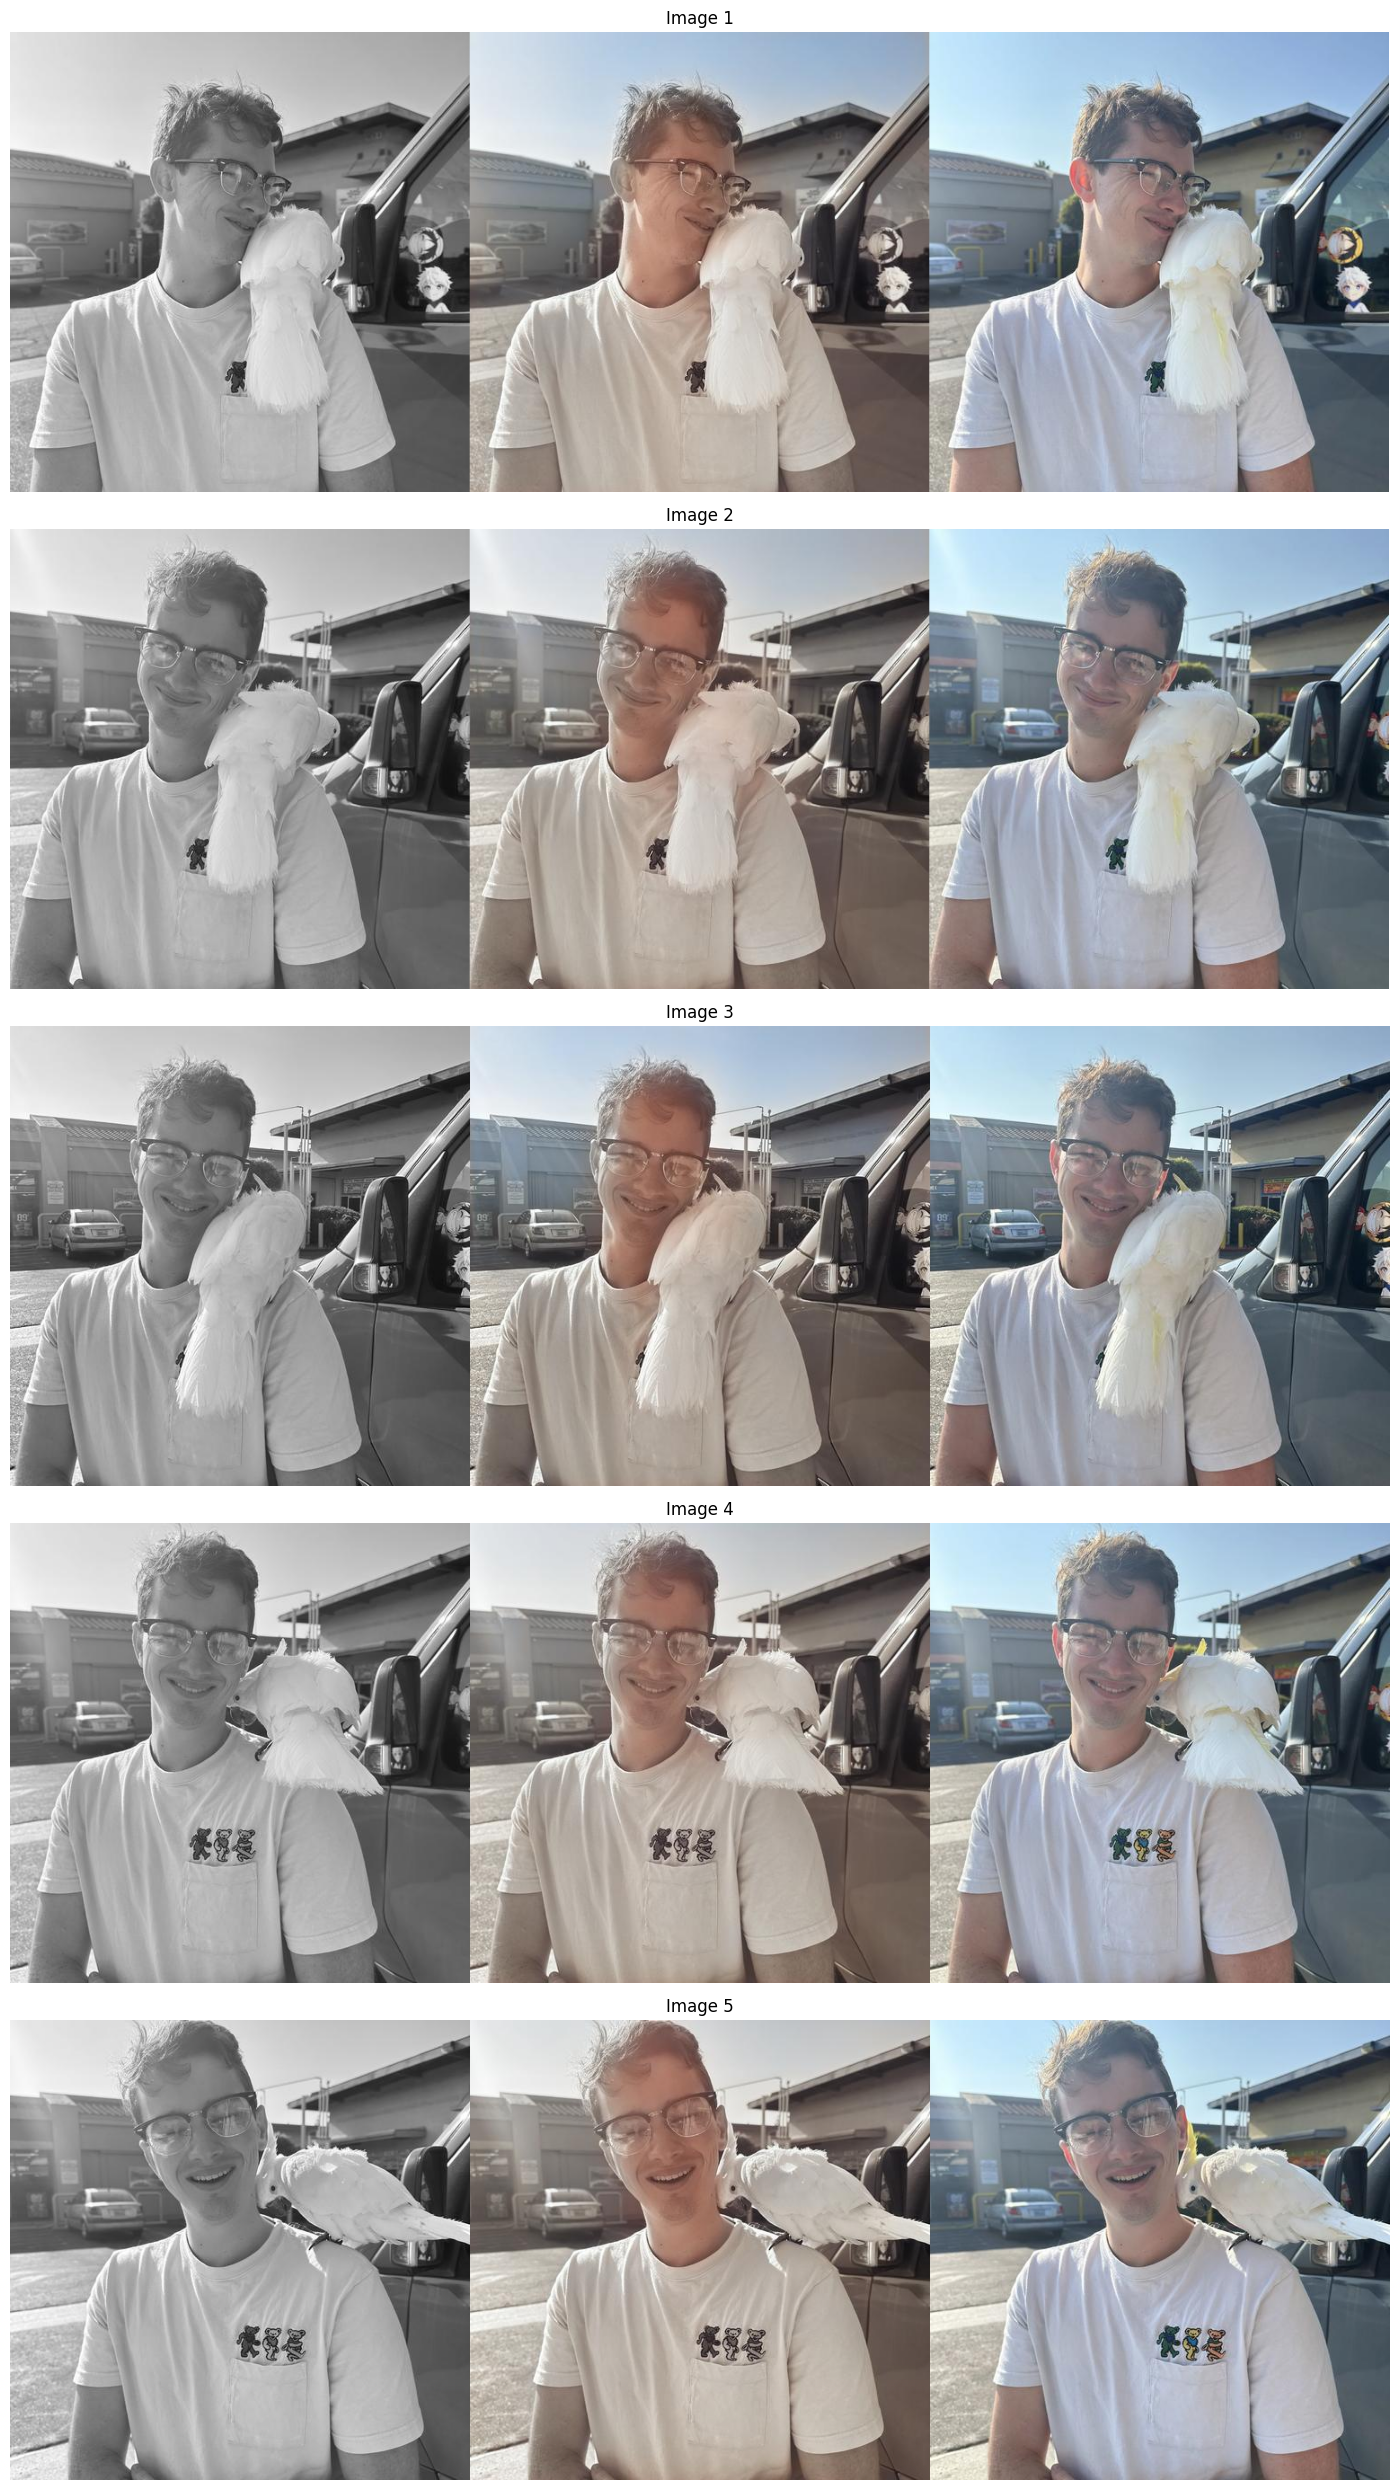

Results without attention:


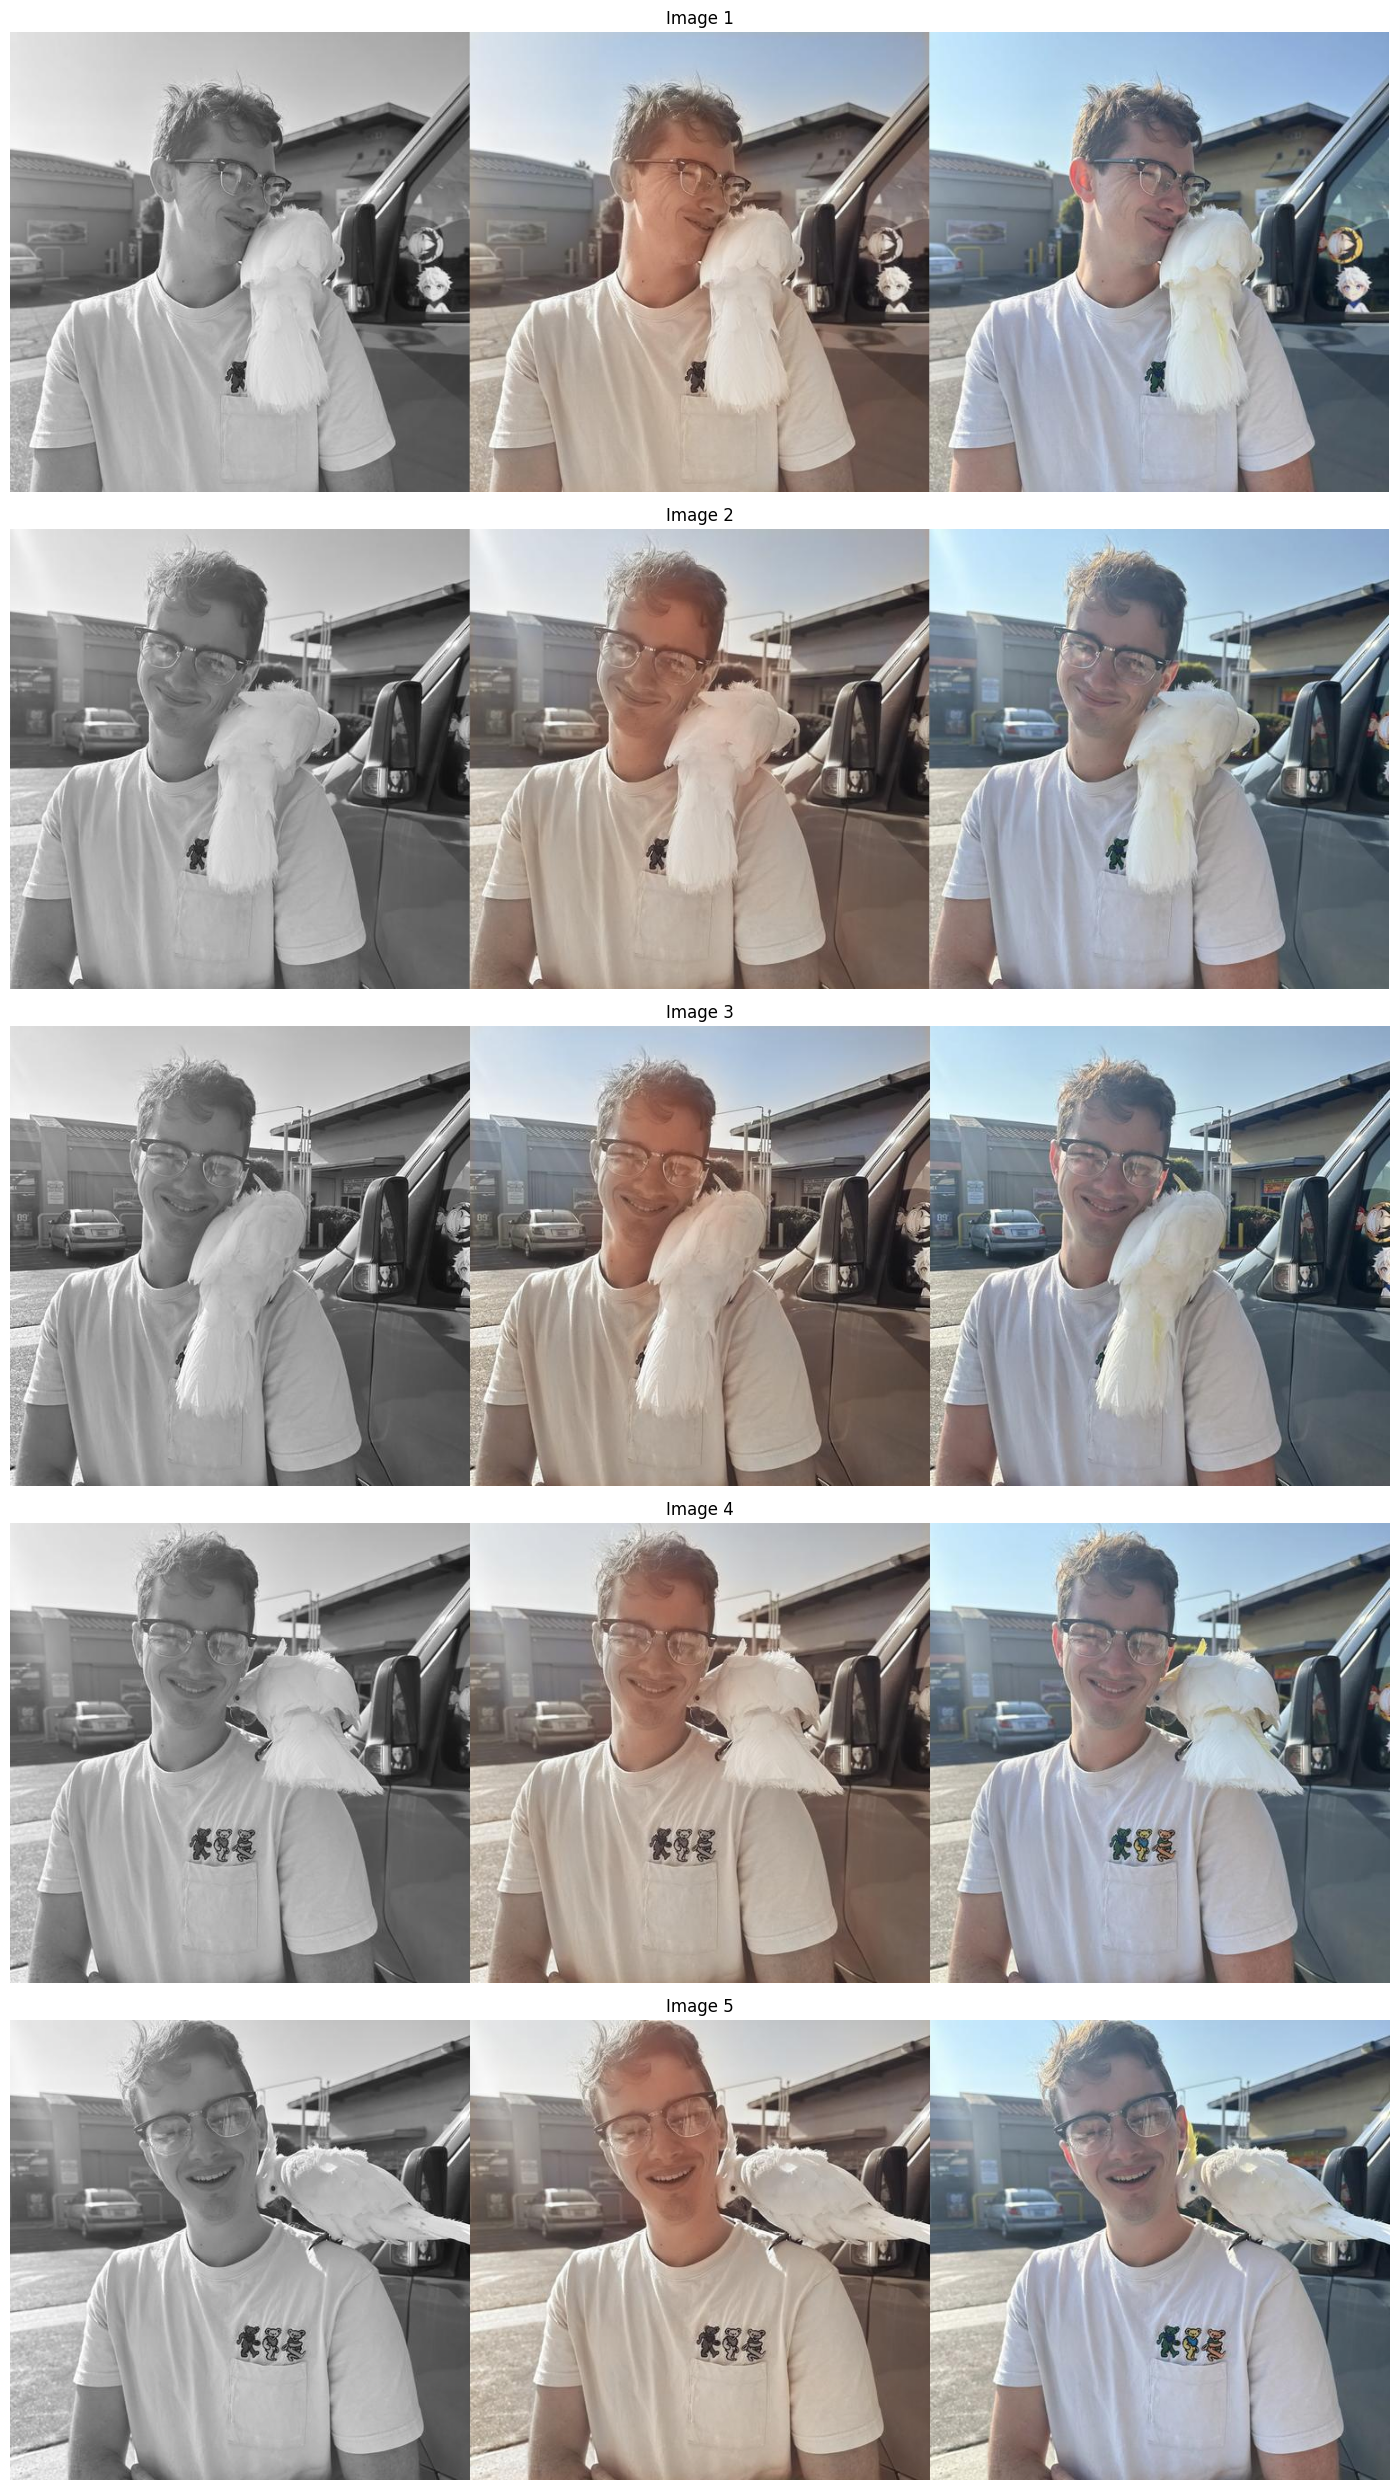

In [10]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

from unet import Unet, CrissCrossAttention
from utils import rgb_to_lab, lab_to_rgb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

l1_loss = nn.L1Loss()

def read_and_resize_image(image_path, size=512):
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    new_size = min(width, height)
    left = (width - new_size) // 2
    top = (height - new_size) // 2
    right = left + new_size
    bottom = top + new_size
    image = image.crop((left, top, right, bottom))
    image = image.resize((size, size), Image.LANCZOS)
    return image

def preprocess_image(image):
    image_np = np.array(image).astype(np.float32)
    image_tensor = torch.from_numpy(image_np).to(device)
    
    l_chan, ab_chan = rgb_to_lab(image_tensor)
    return l_chan, ab_chan

def colorize_and_evaluate(model, l_chan, ab_chan):
    model.eval()
    with torch.no_grad():
        output = model(l_chan.unsqueeze(0))
        loss = l1_loss(output.squeeze(0), ab_chan)
    
    l_rgb = lab_to_rgb(l_chan.unsqueeze(0), torch.zeros_like(output))
    output_rgb = lab_to_rgb(l_chan.unsqueeze(0), output)
    target_rgb = lab_to_rgb(l_chan.unsqueeze(0), ab_chan.unsqueeze(0))
    
    l_rgb = l_rgb.squeeze().cpu().numpy()
    output_rgb = output_rgb.squeeze().cpu().numpy()
    target_rgb = target_rgb.squeeze().cpu().numpy()
    
    stacked_image = np.hstack((l_rgb, output_rgb, target_rgb))
    
    return stacked_image, loss.item()

def process_folder(model, folder_path, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg'))]
    total_loss = 0

    for img_file in tqdm(image_files, desc="Processing images"):
        img_path = os.path.join(folder_path, img_file)
        original_image = read_and_resize_image(img_path)
        l_chan, ab_chan = preprocess_image(original_image)

        stacked_image, loss = colorize_and_evaluate(model, l_chan, ab_chan)
        total_loss += loss

        output_path = os.path.join(output_folder, f"colorized_{img_file}")
        Image.fromarray((stacked_image * 255).astype(np.uint8)).save(output_path)

    avg_loss = total_loss / len(image_files)
    return avg_loss

def display_grid(output_folder, num_images=5):
    processed_images = [f for f in os.listdir(output_folder) if f.startswith("colorized_")]
    num_images = min(num_images, len(processed_images))
    
    fig, axes = plt.subplots(num_images, 1, figsize=(15, 5*num_images))
    if num_images == 1:
        axes = [axes]
    
    for i, img_file in enumerate(processed_images[:num_images]):
        img_path = os.path.join(output_folder, img_file)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

def disable_attention(model):
    for module in model.modules():
        if isinstance(module, CrissCrossAttention):
            module.gamma.data.fill_(0)
    return model

def evaluate_model(model, input_folder, output_folder):
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    avg_loss = process_folder(model, input_folder, output_folder)
    return avg_loss

# Load the model
model = Unet().to(device)
model.load_state_dict(torch.load("unet_attn_final_finetune/model_unet_final.pth", map_location=device))

# Evaluate with attention
input_folder = "test_images"
output_folder_with_attention = "test_images_output_with_attention"
avg_loss_with_attention = evaluate_model(model, input_folder, output_folder_with_attention)

print(f"Average L1 Loss across all images (with attention): {avg_loss_with_attention}")

# Disable attention and evaluate again
model = disable_attention(model)
output_folder_no_attention = "test_images_output_no_attention"
avg_loss_no_attention = evaluate_model(model, input_folder, output_folder_no_attention)

print(f"Average L1 Loss across all images (no attention): {avg_loss_no_attention}")

# Display results
print("Results with attention:")
display_grid(output_folder_with_attention, num_images=5)
print("Results without attention:")
display_grid(output_folder_no_attention, num_images=5)